# Experiment population drift analysis


- toc: false

In [2]:
#hide

from utils.all import *
plt.style.use('seaborn')

In [3]:
#hide

PROJECT = "uw-data-warehouse-prod"
TABLE = "partner_position_master_data_current_v2"
raw_data = download_data(PROJECT, table=TABLE)

Downloading:   0%|          | 0/201712 [00:00<?, ?rows/s]

In [4]:
#hide
TABLE = "partner_position_master_data_v6"
snapshot_data = download_data(PROJECT, table=TABLE)

Downloading:   0%|          | 0/190711 [00:00<?, ?rows/s]

In [5]:
#hide

feats = ['articles_unique_days_viewed_last_1m',
 'jtc_applications_last_3m',
 'days_since_last_activity',
 'team_building_unique_days_viewed_last_6m',
 'customers_unique_days_viewed_last_3m',
 'prospects_unique_days_viewed_last_6m',
 'incentives_unique_days_viewed_last_6m',
 'uw_engagement_unique_days_viewed_last_6m',
 'learning_plans_started_last_3m']

snapshot_filter = snapshot_data.is_live & (snapshot_data.elapsed_days_since_joined >= 274) & (snapshot_data.elapsed_days_since_joined < 679) 

activity_filter = ((raw_data.customers_gathered_last_1y + raw_data.partners_recruited_last_1y) > 0)
activity_snapshot_filter = ((snapshot_data.customers_gathered_last_1y + snapshot_data.partners_recruited_last_1y) > 0)


snapshot_df = snapshot_data.loc[(snapshot_filter) & (activity_snapshot_filter), 
                                feats + ['partner_position_id']].set_index('partner_position_id')
current_df = raw_data.loc[raw_data.is_live & activity_filter, feats + ['partner_position_id']].set_index('partner_position_id')

drift_df = snapshot_df.join(current_df, how='inner', rsuffix='_current')

In [70]:
drift_df

,articles_unique_days_viewed_last_1m,jtc_applications_last_3m,days_since_last_activity,team_building_unique_days_viewed_last_6m,customers_unique_days_viewed_last_3m,prospects_unique_days_viewed_last_6m,incentives_unique_days_viewed_last_6m,uw_engagement_unique_days_viewed_last_6m,learning_plans_started_last_3m,articles_unique_days_viewed_last_1m_current,jtc_applications_last_3m_current,days_since_last_activity_current,team_building_unique_days_viewed_last_6m_current,customers_unique_days_viewed_last_3m_current,prospects_unique_days_viewed_last_6m_current,incentives_unique_days_viewed_last_6m_current,uw_engagement_unique_days_viewed_last_6m_current,learning_plans_started_last_3m_current
partner_position_id,,,,,,,,,,,,,,,,,,
N62557,1,6,176,5,11,2,6,7,0,0,27,9,10,16,2,10,18,0
N62652,0,0,158,3,0,0,0,1,0,0,0,229,0,0,0,0,0,0
N66615,0,0,114,0,0,0,0,0,0,0,0,191,1,0,0,1,1,0
N66628,0,3,83,2,1,1,1,1,0,0,0,128,0,0,0,0,0,0
N66672,0,1,72,0,0,0,0,0,0,0,0,296,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N79557,0,0,108,0,0,0,0,3,0,0,0,206,0,1,0,1,1,0
N79558,0,0,194,1,0,0,0,1,0,0,8,30,6,1,0,3,2,0
N79561,5,42,41,31,27,7,23,23,1,0,11,46,5,11,6,3,6,1


In [27]:
#hide

import seaborn as sns

snap = drift_df.loc[:, feats]
curr = drift_df.loc[:, [f + '_current' for f in feats]]
curr.columns = feats
snap['snap_date'] = 'snapshot'
curr['snap_date'] = 'current'
long_df = pd.concat([snap, curr])
long_df['count'] = ''

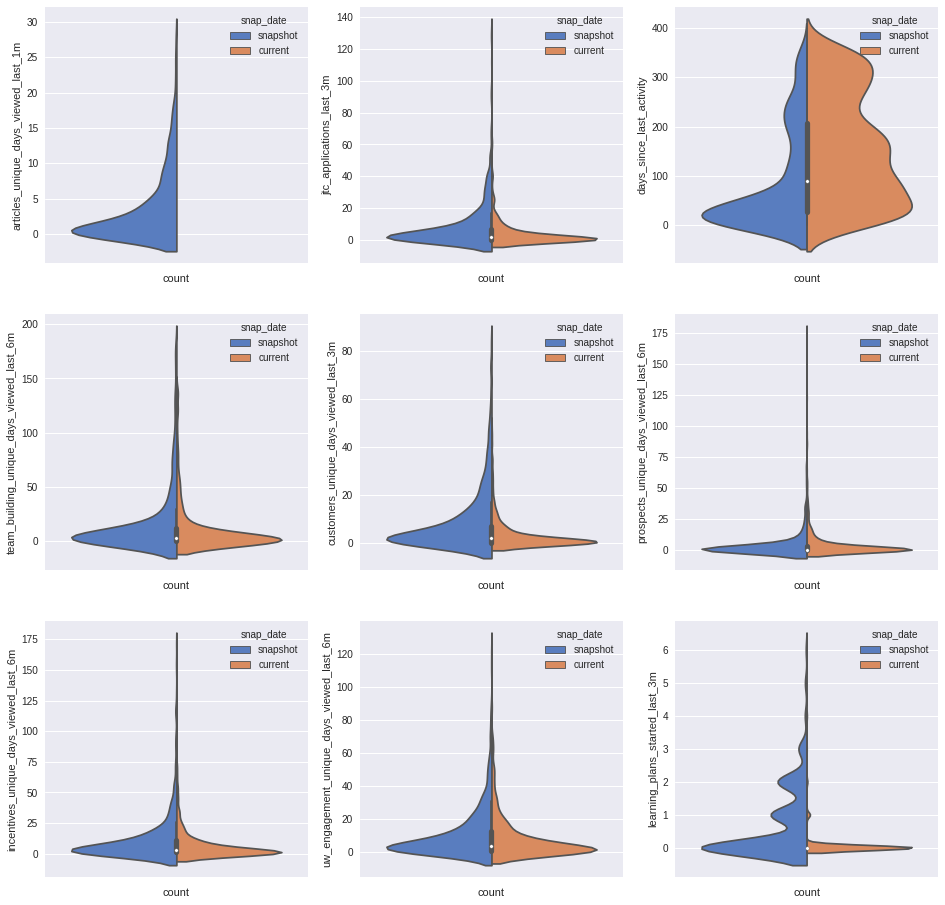

In [29]:
#collapse

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 16))
for i, f in enumerate(feats):
    sns.violinplot(data=long_df, x='count', y=f, hue='snap_date', scale='count',
                ax=axes[i // 3][i % 3], split=True, palette='muted')

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


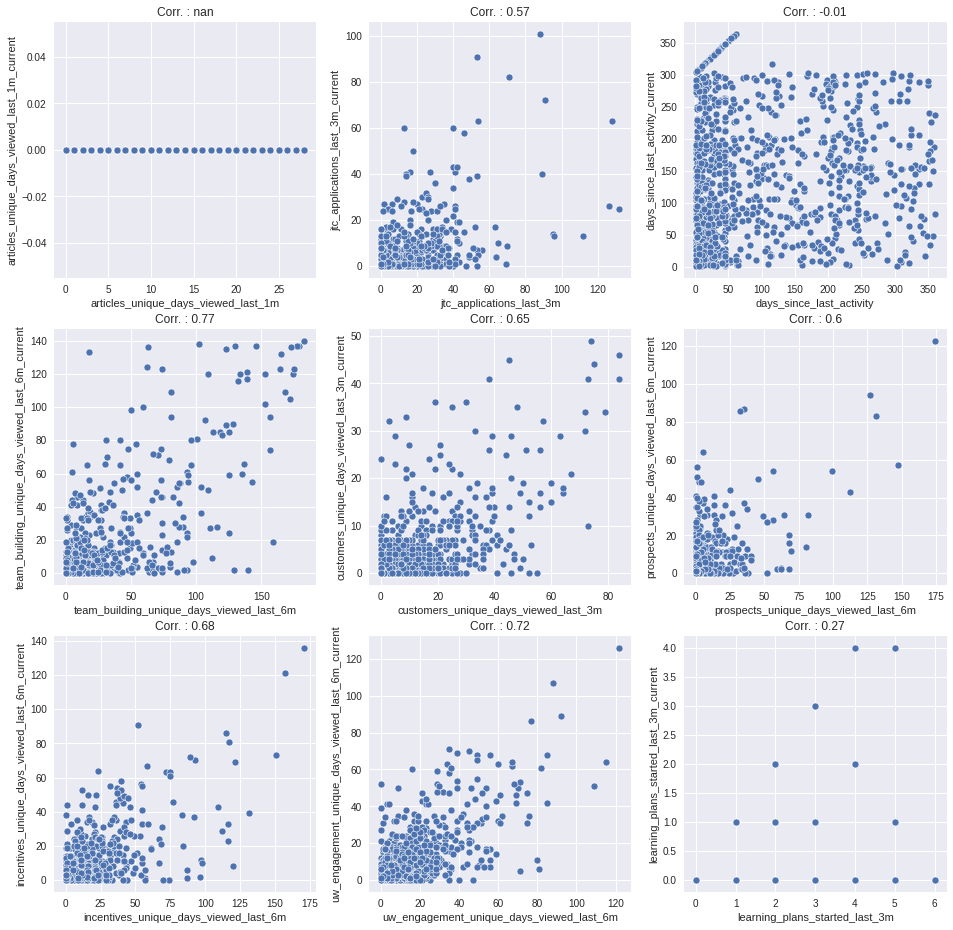

In [48]:
#collapse

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(16, 16))
for i, f in enumerate(feats):
    corr = round(np.corrcoef(drift_df[f], drift_df[f + '_current'])[0][1], 2)
    axes[i // 3][i % 3].set_title(f'Corr. : {corr}')
    sns.scatterplot(x=drift_df[f], y=drift_df[f + '_current'],
                ax=axes[i // 3][i % 3])

In [ ]:
#collapse

sorted_f = []
for t in zip(feats, [f + '_current' for f in feats]): sorted_f += list(t)

drift_df.loc[:, sorted_f].agg(['mean', 'std']).T

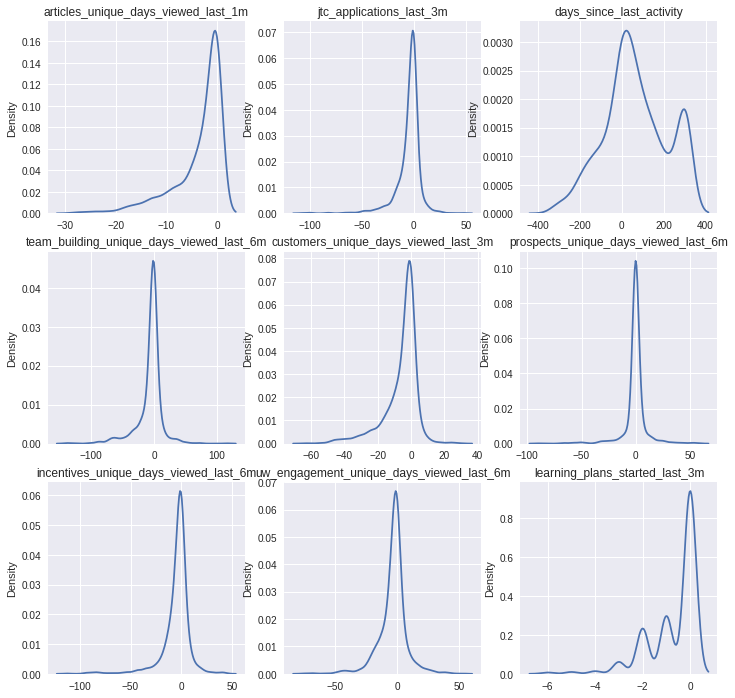

In [64]:
#collapse

changes_df = pd.DataFrame({f+'_change': drift_df[f + '_current'] - drift_df[f] for f in feats})
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
for i, f in enumerate(feats):
    axes[i // 3][i % 3].set_title(f)
    sns.kdeplot(data=changes_df.loc[:, [f + '_change']], 
                ax=axes[i // 3][i % 3], legend=False)

In [ ]:
#collapse

#Cohen's d for same samples of same size

from scipy.stats import ttest_rel
from math import sqrt
def cohen_d(d1, d2):
    s = sqrt((d1.var() + d2.var()) / 2)
    return (d1.mean() - d2.mean()) / s

In [69]:
ttest_rel(drift_df[f + '_current'], 
          drift_df[f])

Ttest_relResult(statistic=-22.54718854462583, pvalue=1.5775990537902972e-93)

In [68]:
#collapse

pd.DataFrame({'cohen_d': [cohen_d(drift_df[f + '_current'], 
          drift_df[f]) for f in feats],
          'effect_size': [drift_df[f + '_current'].mean() -  
          drift_df[f].mean() for f in feats],
          'p-value': [ttest_rel(drift_df[f + '_current'], 
          drift_df[f]).pvalue for f in feats]}, index=feats)

,cohen_d,effect_size,p-value
articles_unique_days_viewed_last_1m,-1.007760,-3.572917,7.914522e-105
jtc_applications_last_3m,-0.393700,-4.797743,1.241185e-38
days_since_last_activity,0.622306,65.663194,4.952899e-46
team_building_unique_days_viewed_last_6m,-0.227607,-6.433160,1.149598e-25
customers_unique_days_viewed_last_3m,-0.556613,-5.840278,3.126908e-71
prospects_unique_days_viewed_last_6m,-0.032423,-0.386285,2.287187e-01
incentives_unique_days_viewed_last_6m,-0.293459,-4.824653,1.765160e-29
uw_engagement_unique_days_viewed_last_6m,-0.210492,-3.125000,2.344539e-20
learning_plans_started_last_3m,-0.867079,-0.697049,1.577599e-93
